In [1]:
import numpy as np
from astropy import units as u
from astropy.coordinates import cartesian_to_spherical
from matplotlib import animation
from poliastro.bodies import Moon
from poliastro.twobody import Orbit

from src import CraterDetector
from src.common.conics import *
from src.common.data import DataGenerator
from src.matching import CraterDatabase
from scipy.integrate import ode

In [2]:
db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv",
                              latlims=(0, 20),
                              longlims=(0, 30),
                              diamlims=(5, 40),
                              radius=180,
                              )

In [3]:
cam = DataGenerator.from_robbins_dataset(file_path="../data/lunar_crater_database_robbins_2018.csv",
                                         diamlims=(4, 40),
                                         axis_threshold=(1, 250))

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [8]:
cda = CraterDetector()
cda.load_state_dict(torch.load("../blobs/CraterRCNN.pth"))
cda.to('cuda')
cda.eval()
print()

In [4]:
from src.matching.position_estimation import systems_dynamics_matrix, hx, HJacobian_at

In [5]:
a = 2000 * u.km
ecc = 0.005 * u.one
inc = 90 * u.deg
raan = 18 * u.deg
argp = 0 * u.deg
nu = 0 * u.deg

orb = Orbit.from_classical(Moon, a, ecc, inc, raan, argp, nu)

In [50]:
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_discrete_white_noise
ekf = ExtendedKalmanFilter(dim_x=6, dim_z=3)

dt = 0.5
t_range = np.arange(0, 100, dt)

cam.position = np.array(orb.r)[:, None]
cam.point_nadir()

ekf.P[:3, :3] *= 1
ekf.P[3:, 3:] *= 0.1
ekf.Q[:3, :3] = Q_discrete_white_noise(3, dt=dt, var=0.1)
ekf.Q[3:, 3:] = Q_discrete_white_noise(3, dt=dt, var=0.01)
ekf.Q

array([[0.0015625 , 0.00625   , 0.0125    , 0.        , 0.        ,
        0.        ],
       [0.00625   , 0.025     , 0.05      , 0.        , 0.        ,
        0.        ],
       [0.0125    , 0.05      , 0.1       , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.00015625, 0.000625  ,
        0.00125   ],
       [0.        , 0.        , 0.        , 0.000625  , 0.0025    ,
        0.005     ],
       [0.        , 0.        , 0.        , 0.00125   , 0.005     ,
        0.01      ]])

In [51]:
initialized_position = np.concatenate((np.array(orb.r) + np.random.uniform(-25, 25, 3),
                                       np.array(orb.v) + np.random.uniform(-0.1, 0.1, 3)))[:, None]
ekf.x = initialized_position
cam.position = initialized_position[:3]
cam.point_nadir()
ground_truth = np.zeros((len(t_range), 6, 1))
predictions = np.zeros((len(t_range), 6, 1))
update_mask = np.full(len(t_range), False, dtype=bool)

match_trial_args = dict(
    sigma_pix=4,
    k=30,
    max_distance=0.040,
    batch_size=1500,
    residual_threshold=0.020,
    max_trials=1500
)


for i, t in enumerate(t_range):
    ekf.F = np.identity(6) + systems_dynamics_matrix(ekf.x)*dt
    x_true = np.array(orb.propagate(t*u.second).r)[:, None]
    v_true = np.array(orb.propagate(t*u.second).v)[:, None]
    cam.position = x_true
    # cam.point_nadir()
    ground_truth[i] = np.concatenate((x_true, v_true))
    image = cam.generate_image()
    image = torch.as_tensor(image[None, None, ...]).to('cuda')
    with torch.no_grad():
        pred = cda(image)[0]

    scores = pred['scores']
    A_detections = pred['ellipse_matrices'][scores > 0.75].cpu().numpy()

    if len(A_detections) < 4:
        continue
    position_regressor = db.query_position(A_detections, T=cam.T, K=cam.K,
                                           **match_trial_args)

    if position_regressor.reprojection_match():
        latest_position_error = LA.norm(position_regressor.est_pos_verified - ekf.x[:3])
        if latest_position_error < 50:
            print(f"Update! Error: {LA.norm(position_regressor.est_pos_verified - cam.position)*1000:.1f} m")
            update_mask[i] = True
            ekf.update(position_regressor.est_pos_verified, HJacobian_at, hx)


    ekf.predict()
    print(f"[t = {t:03.1f}s, lat={cam.latitude:.1f}, long={cam.longitude:.1f}] EKF position error:  {LA.norm(ekf.x[:3] - cam.position):12.2f} km")
    predictions[i] = ekf.x

[t = 0.0s, lat=0.0, long=18.0] EKF position error:         27.31 km
Update! Error: 529.3 m
[t = 0.5s, lat=0.0, long=18.0] EKF position error:         13.11 km
Update! Error: 1744.4 m
[t = 1.0s, lat=0.0, long=18.0] EKF position error:          8.14 km
Update! Error: 458.2 m
[t = 1.5s, lat=0.1, long=18.0] EKF position error:          4.86 km
Update! Error: 2956.6 m
[t = 2.0s, lat=0.1, long=18.0] EKF position error:          2.11 km
Update! Error: 897.1 m
[t = 2.5s, lat=0.1, long=18.0] EKF position error:          0.85 km
Update! Error: 377.9 m
[t = 3.0s, lat=0.1, long=18.0] EKF position error:          1.67 km
Update! Error: 2666.3 m
[t = 3.5s, lat=0.2, long=18.0] EKF position error:          1.60 km
Update! Error: 1843.7 m
[t = 4.0s, lat=0.2, long=18.0] EKF position error:          1.79 km
Update! Error: 2812.5 m
[t = 4.5s, lat=0.2, long=18.0] EKF position error:          1.81 km
Update! Error: 513.6 m
[t = 5.0s, lat=0.2, long=18.0] EKF position error:          2.07 km
Update! Error: 11

In [52]:
error = ground_truth - predictions
err_r, err_lat_rad, err_lon_rad = np.array(cartesian_to_spherical(*predictions[:, :3].squeeze().T) -
                                           np.array(cartesian_to_spherical(*ground_truth[:, :3].squeeze().T)))

err_horz_lat = LA.norm(ground_truth[:, :3], axis=(1,2)) * err_lat_rad
err_horz_lon = LA.norm(ground_truth[:, :3], axis=(1,2)) * err_lon_rad

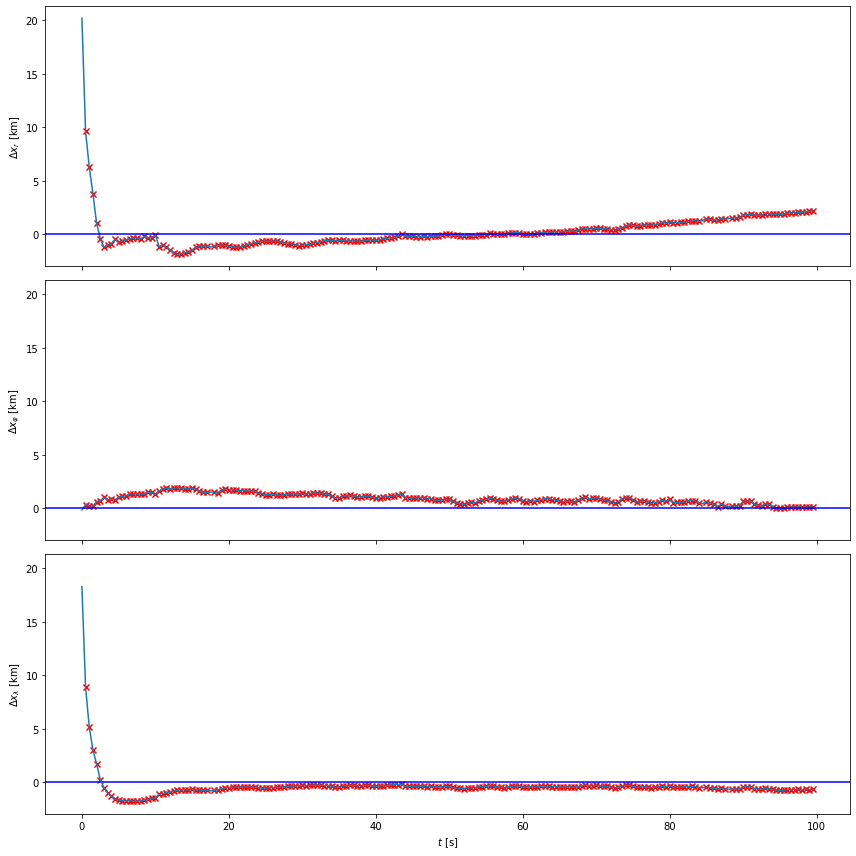

In [53]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex='all', sharey='all')

axes[0].plot(t_range, err_r)
axes[0].scatter(t_range[update_mask], err_r[update_mask], marker='x', color='r')
axes[0].axhline(y=0, color='b', linestyle='-')
axes[0].set_ylabel(r'$\Delta x_{r}$ [km]')
axes[1].plot(t_range, err_horz_lat)
axes[1].scatter(t_range[update_mask], err_horz_lat[update_mask], marker='x', color='r')
axes[1].axhline(y=0, color='b', linestyle='-')
axes[1].set_ylabel(r'$\Delta x_{\varphi}$ [km]')
axes[2].scatter(t_range[update_mask], err_horz_lon[update_mask], marker='x', color='r')
axes[2].axhline(y=0, color='b', linestyle='-')
axes[2].plot(t_range, err_horz_lon)
axes[2].set_ylabel(r'$\Delta x_{\lambda}$ [km]')

axes[2].set_xlabel(r'$t$ [s]')
fig.tight_layout()
fig.savefig('../output/orbit_simulation_test.png')

In [60]:
cam2 = DataGenerator.from_robbins_dataset(file_path="../data/lunar_crater_database_robbins_2018.csv",
                                          diamlims=(4, 40),
                                          axis_threshold=(1, 250),
                                          resolution=1024
                                          )

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


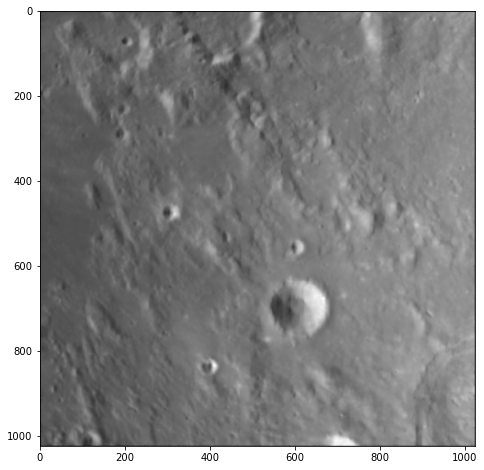

In [78]:
fps = 30
n_seconds = 15
fig, ax = plt.subplots(figsize=(8,8))
cam2.position = np.array(orb.r)[:, None]
cam2.point_nadir()
image = cam2.generate_image()
im = ax.imshow(image, cmap='gray')
# ax.axis('off')
# def animation_func(i):
#     if i % fps == 0:
#         print('.', end ='' )
#     cam2.position = np.array(orb.propagate(i*dt*u.second).r)[:, None]
#     cam2.rotate('pitch', i//fps*0.003)
#     image = cam2.generate_image()
#     # plot_conics(cam2.craters_in_image(), ax=ax)
#     im.set_array(image)
#     return [im]
#
# anim = animation.FuncAnimation(
#     fig,
#     animation_func,
#     frames = n_seconds * fps,
#     interval = 1000 / fps, # in ms
# )
# fig.tight_layout()
#
# anim.save('../output/test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

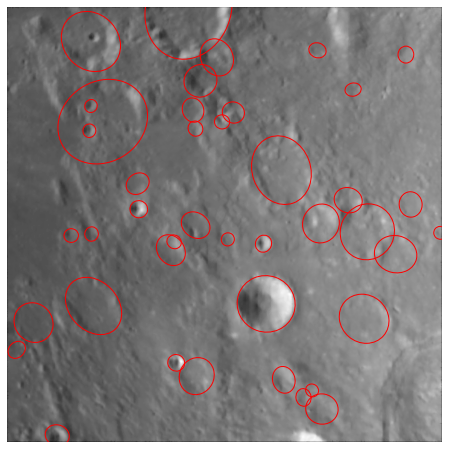

In [96]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis('off')
ax.imshow(image, cmap='gray')
plot_conics(cam2.craters_in_image(), resolution=(1024, 1024), ax=ax)
ax.collections

In [81]:
image.shape


(1024, 1024)